In [1]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
from sklearn.model_selection import train_test_split
import pickle
from MVDD.MVDD import MVDD
import MVDD.MVDD_Generator as mvGen

plt.rc('font', size=12)
warnings.filterwarnings('ignore')

# Hemo

In [2]:
#Load original dataframes
hemoData = pd.read_csv('Data/Preprocessed Data/Cluster_Hemo.csv', index_col='DEIDNUM')
allScores = hemoData['Score']
death = hemoData['ScoreDeath']
rehosp = hemoData['ScoreRehosp']
readm = hemoData['ScoreReadmission']
hemoData

,RAP,PAS,PAD,PAMN,PCWP,PCWPMod,PCWPA,PCWPMN,CO,CI,...,PAPP,SVR,RAT,PPRatio,Age,EjF,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
DEIDNUM,,,,,,,,,,,,,,,,,,,,,
72,24.0,42.0,24.0,30.0,36.0,36.0,36.0,36.0,2.20,1.60,...,0.428571,5357.575758,0.666667,0.266667,88.0,25.0,5,5,5,4
72,18.0,42.0,24.0,30.0,24.0,24.0,24.0,28.0,3.10,2.00,...,0.428571,3509.677419,0.750000,0.272727,88.0,25.0,3,3,4,2
81,10.0,40.0,20.0,27.0,18.0,18.0,18.0,20.0,4.52,2.02,...,0.500000,1982.300885,0.555556,0.242857,69.0,20.0,1,2,1,1
81,12.0,35.0,15.0,25.0,17.0,17.0,17.0,14.0,4.65,2.08,...,0.571429,1772.043011,0.705882,0.571429,69.0,20.0,1,2,1,1
814,3.0,51.0,19.0,30.0,18.0,18.0,18.0,18.0,4.10,2.00,...,0.627451,2621.138211,0.166667,0.566667,58.0,NaN,3,3,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,57.0,30.0,4,4,3,5
99302,19.0,87.0,37.0,54.0,44.0,44.0,44.0,NaN,3.90,2.00,...,0.574713,2666.666667,0.431818,0.642857,41.0,15.0,5,5,5,4
99302,11.0,70.0,28.0,44.0,28.0,28.0,28.0,NaN,5.30,2.70,...,0.600000,2440.251572,0.392857,1.088608,41.0,15.0,3,3,4,2


In [3]:
# Preprocess and create training and testing sets
hemo = hemoData.drop('Score', axis=1)
hemo = hemo.drop('ScoreDeath', axis=1)
hemo = hemo.drop('ScoreRehosp', axis=1)
hemo = hemo.drop('ScoreReadmission', axis=1)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)

xData = hemo
yData = allScores
xData.shape, yData.shape

((418, 27), (418,))

## All Scores Label

In [4]:
# #Perform Grid search to find best parameter set
# trialParams = {'criterion': ('gini', 'entropy'), 'max_depth': [3, 5, 7, 10, 13, 15, 20, 25, 30, None], 
#                'min_samples_leaf':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30]}

# mvGen.findBestModelParams(xData, yData, trialParams)

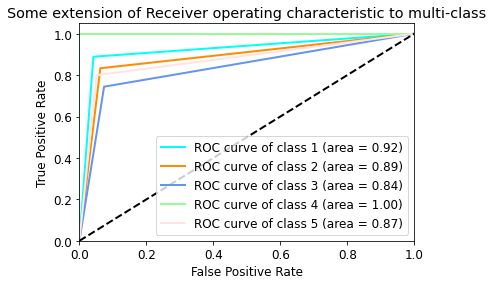

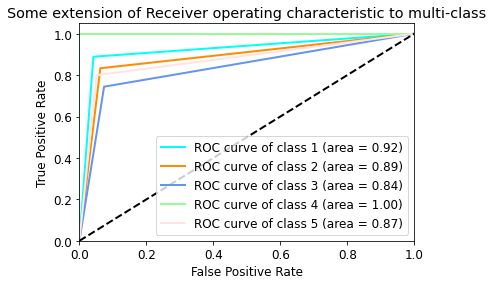

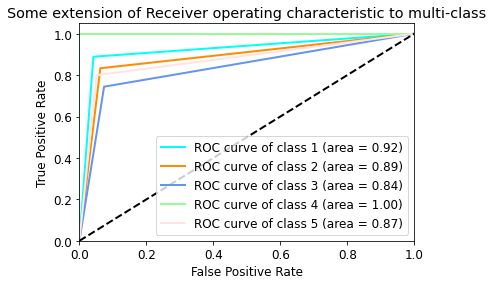

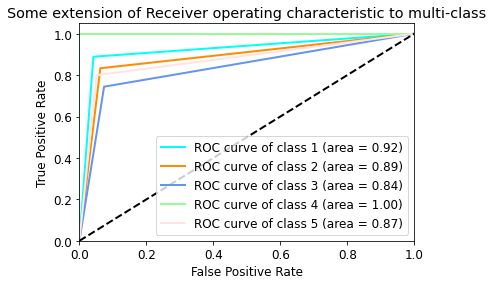

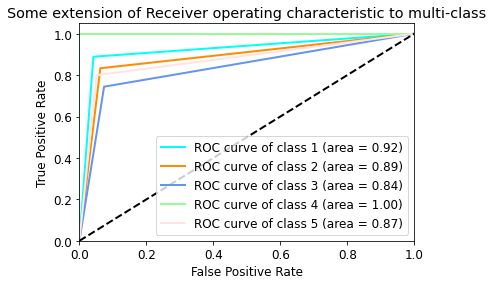

accuracy is: 0.826086956521739
precision_weighted is 0.8289525367998326
recall_weighted is 0.826086956521739
f1_weighted is 0.8260144084352902


In [5]:
mvdd= mvGen.generateTreeCrossValidation(xData=xData, yData=yData, classes=["1", "2", "3", "4", "5"], 
                                  learningCriteria='gini', maxLevels=None, minSamplesPerLeaf=1, 
                                                 modelName='TreeFiles/Hemo_AllOutcomes', numFolds=5)


In [6]:
# accList = scores['test_accuracy']
# print("Accuracy: %0.3f (+/- %0.3f)" % (accList.mean(), accList.std() * 2))
# precList = scores['test_precision_weighted']
# print("Precision: %0.3f (+/- %0.3f)" % (precList.mean(), precList.std() * 2))
# recList = scores['test_recall_weighted']
# print("Recall: %0.3f (+/- %0.3f)" % (recList.mean(), recList.std() * 2))
# f1List = scores['test_f1_weighted']
# print("F1: %0.3f (+/- %0.3f)" % (f1List.mean(), f1List.std() * 2))
# rocList = scores['test_roc_auc_ovr_weighted']
# print("AUC: %0.3f (+/- %0.3f)" % (rocList.mean(), rocList.std() * 2))

# TODO Plot ROC / AUC Curves for each class somehow??
Example: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

## Death Label

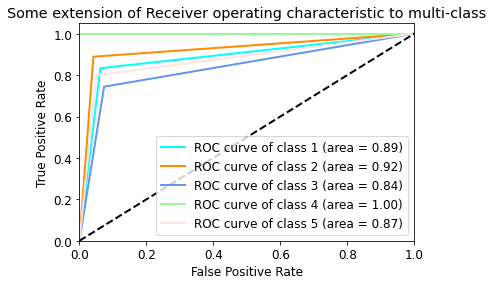

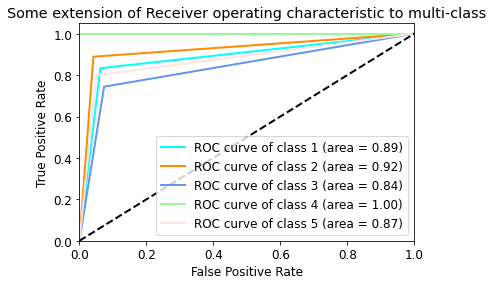

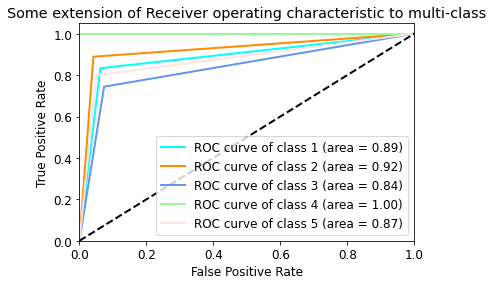

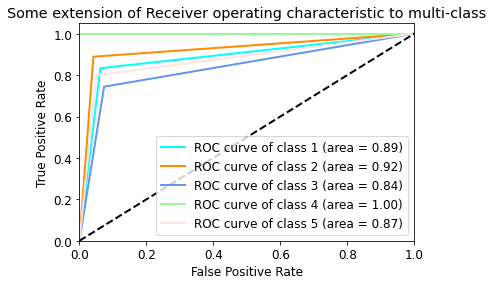

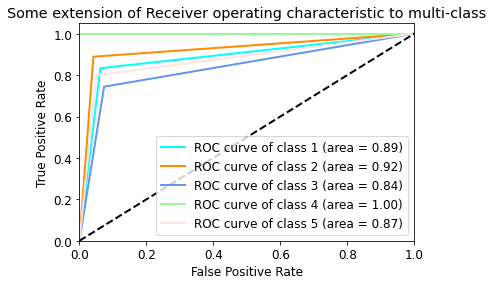

accuracy is: 0.826086956521739
precision_weighted is 0.8289525367998326
recall_weighted is 0.826086956521739
f1_weighted is 0.8260144084352902


In [7]:
yData = death

mvdd= mvGen.generateTreeCrossValidation(xData=xData, yData=yData, classes=["1", "2", "3", "4", "5"], 
                                  learningCriteria='gini', maxLevels=None, minSamplesPerLeaf=1, 
                                                 modelName='TreeFiles/Hemo_Death', numFolds=5)


In [8]:
# accList = scores['test_accuracy']
# print("Accuracy: %0.3f (+/- %0.3f)" % (accList.mean(), accList.std() * 2))
# precList = scores['test_precision_weighted']
# print("Precision: %0.3f (+/- %0.3f)" % (precList.mean(), precList.std() * 2))
# recList = scores['test_recall_weighted']
# print("Recall: %0.3f (+/- %0.3f)" % (recList.mean(), recList.std() * 2))
# f1List = scores['test_f1_weighted']
# print("F1: %0.3f (+/- %0.3f)" % (f1List.mean(), f1List.std() * 2))
# rocList = scores['test_roc_auc_ovr_weighted']
# print("AUC: %0.3f (+/- %0.3f)" % (rocList.mean(), rocList.std() * 2))

## Rehospitalization Label

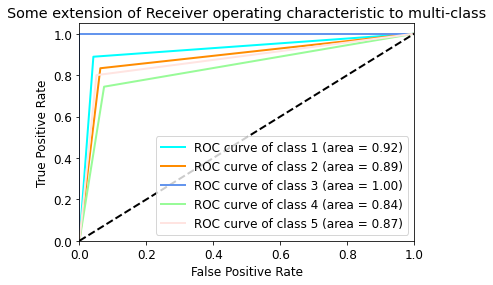

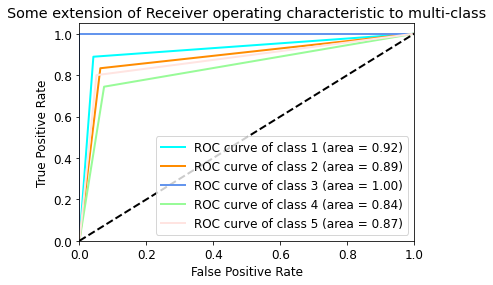

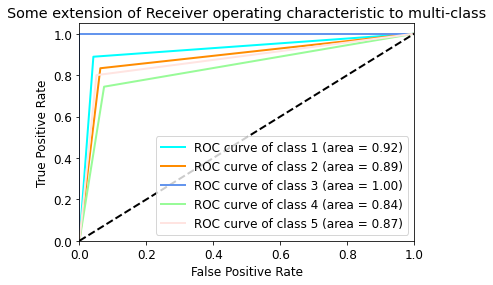

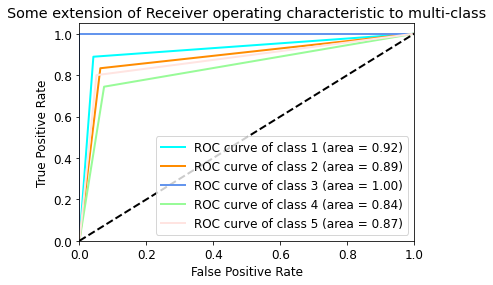

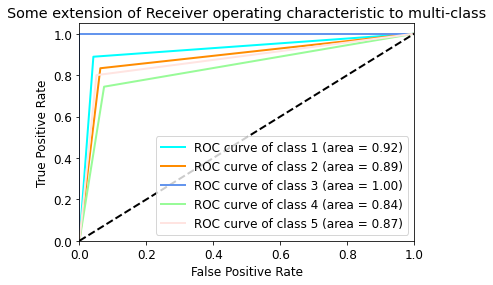

accuracy is: 0.826086956521739
precision_weighted is 0.8289525367998326
recall_weighted is 0.826086956521739
f1_weighted is 0.8260144084352902


In [9]:
yData = rehosp

mvdd= mvGen.generateTreeCrossValidation(xData=xData, yData=yData, classes=["1", "2", "3", "4", "5"], 
                                  learningCriteria='gini', maxLevels=None, minSamplesPerLeaf=1, 
                                                 modelName='TreeFiles/Hemo_Rehosp', numFolds=5)


In [10]:
# accList = scores['test_accuracy']
# print("Accuracy: %0.3f (+/- %0.3f)" % (accList.mean(), accList.std() * 2))
# precList = scores['test_precision_weighted']
# print("Precision: %0.3f (+/- %0.3f)" % (precList.mean(), precList.std() * 2))
# recList = scores['test_recall_weighted']
# print("Recall: %0.3f (+/- %0.3f)" % (recList.mean(), recList.std() * 2))
# f1List = scores['test_f1_weighted']
# print("F1: %0.3f (+/- %0.3f)" % (f1List.mean(), f1List.std() * 2))
# rocList = scores['test_roc_auc_ovr_weighted']
# print("AUC: %0.3f (+/- %0.3f)" % (rocList.mean(), rocList.std() * 2))

## Readmission Label

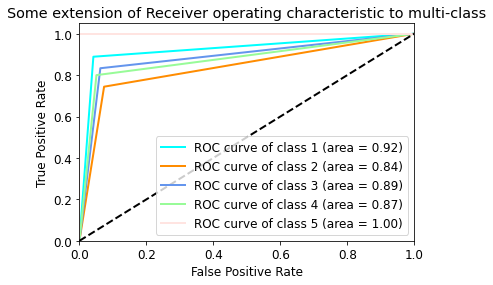

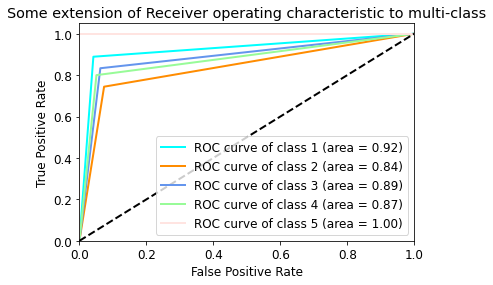

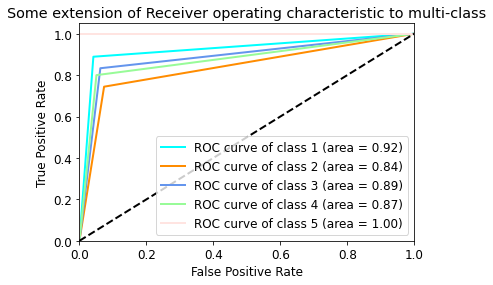

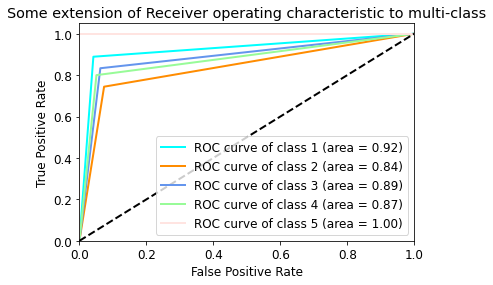

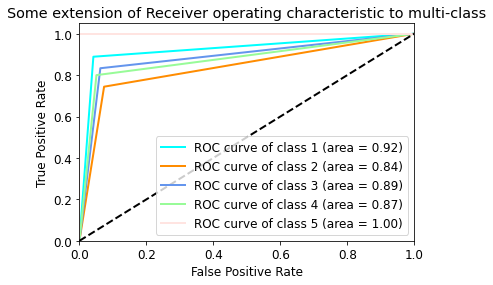

accuracy is: 0.826086956521739
precision_weighted is 0.8289525367998326
recall_weighted is 0.826086956521739
f1_weighted is 0.8260144084352902


In [12]:
yData = readm

mvdd= mvGen.generateTreeCrossValidation(xData=xData, yData=yData, classes=["1", "2", "3", "4", "5"], 
                                  learningCriteria='gini', maxLevels=None, minSamplesPerLeaf=1, 
                                                 modelName='TreeFiles/Hemo_Readmission', numFolds=5)

In [ ]:
# accList = scores['test_accuracy']
# print("Accuracy: %0.3f (+/- %0.3f)" % (accList.mean(), accList.std() * 2))
# precList = scores['test_precision_weighted']
# print("Precision: %0.3f (+/- %0.3f)" % (precList.mean(), precList.std() * 2))
# recList = scores['test_recall_weighted']
# print("Recall: %0.3f (+/- %0.3f)" % (recList.mean(), recList.std() * 2))
# f1List = scores['test_f1_weighted']
# print("F1: %0.3f (+/- %0.3f)" % (f1List.mean(), f1List.std() * 2))
# rocList = scores['test_roc_auc_ovr_weighted']
# print("AUC: %0.3f (+/- %0.3f)" % (rocList.mean(), rocList.std() * 2))

# All Data

In [13]:
#Load original dataframes
allDataOrig = pd.read_csv('Data/Preprocessed Data/Cluster_AllData.csv', index_col='DEIDNUM')
allScores = allDataOrig['Score']
death = allDataOrig['ScoreDeath']
rehosp = allDataOrig['ScoreRehosp']
readm = allDataOrig['ScoreReadmission']

allDataOrig

,Age,Gender,Race,Wt,BMI,InitialHospDays,TotalHospDays,NYHA,MLHFS,AF,...,HR,PV,MAP,PP,PPP,PPRatio,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
DEIDNUM,,,,,,,,,,,,,,,,,,,,,
72,88.0,2.0,1.0,57.100000,26.424175,9.0,16.0,4.0,76.0,1.0,...,104.0,12.452563,139.333333,26.0,0.276596,0.250000,4,4,4,4
72,88.0,2.0,1.0,52.000000,24.064047,9.0,16.0,3.0,76.0,1.0,...,92.0,12.452563,126.000000,26.0,0.302326,0.282609,4,4,4,4
81,69.0,1.0,1.0,102.363636,32.307675,5.0,13.0,4.0,21.0,1.0,...,70.0,-3.346568,125.333333,32.0,0.363636,0.457143,5,5,5,5
81,69.0,1.0,1.0,100.454545,31.705134,5.0,13.0,2.0,21.0,1.0,...,72.0,-3.346568,105.666667,34.0,0.441558,0.472222,5,5,5,5
86,56.0,2.0,2.0,98.636364,40.016375,3.0,3.0,4.0,NaN,0.0,...,86.0,5.478621,146.666667,30.0,0.300000,0.348837,2,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99302,41.0,1.0,2.0,97.400000,40.541103,21.0,21.0,NaN,79.0,0.0,...,75.0,25.535155,130.000000,55.0,0.550000,0.733333,5,5,5,5
99912,46.0,1.0,1.0,78.636364,25.677180,2.0,2.0,4.0,89.0,0.0,...,67.0,-13.911732,174.666667,38.0,0.316667,0.567164,2,2,2,1
99912,46.0,1.0,1.0,78.200000,25.534694,2.0,2.0,3.0,89.0,0.0,...,60.0,-13.911732,140.666667,24.0,0.255319,0.400000,2,2,2,1


In [14]:
# Preprocess and create training and testing sets
allData = allDataOrig.drop('Score', axis=1)
allData = allData.drop('ScoreDeath', axis=1)
allData = allData.drop('ScoreRehosp', axis=1)
allData = allData.drop('ScoreReadmission', axis=1)
allData = allData.replace(np.inf, 0)
allData = allData.fillna(0)

xData = allData
yData = allScores

## All Scores Label

In [15]:
#Perform Grid search to find best parameter set
trialParams = {'criterion': ('gini', 'entropy'), 'max_depth': [3, 5, 7, 10, 13, 15, 20, 25, 30, None], 
               'min_samples_leaf':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30]}

mvGen.findBestModelParams(xData, yData, trialParams)

Best parameters set found on training set:
{'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 3}
              precision    recall  f1-score   support

           1       0.97      0.99      0.98       142
           2       0.99      1.00      0.99       253
           3       0.99      0.96      0.98       107
           4       0.99      0.99      0.99       203
           5       1.00      0.98      0.99       161

    accuracy                           0.99       866
   macro avg       0.99      0.98      0.99       866
weighted avg       0.99      0.99      0.99       866



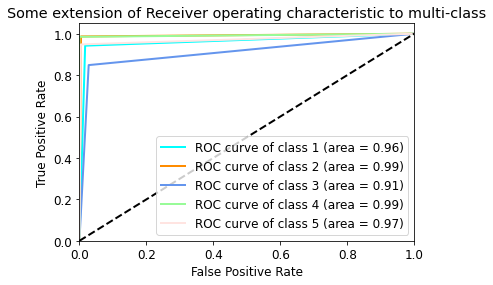

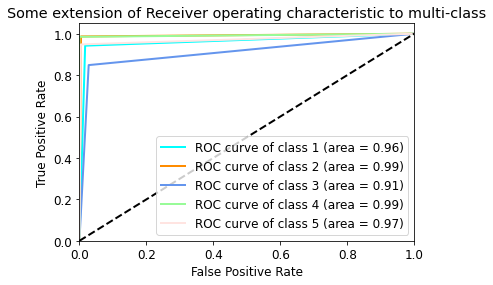

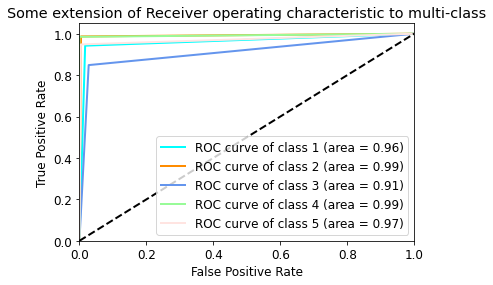

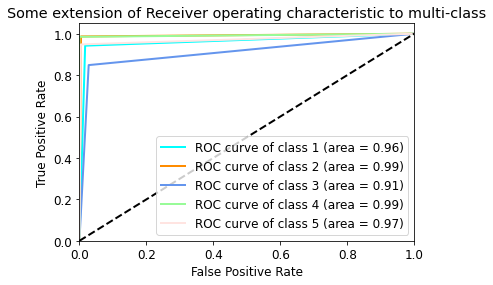

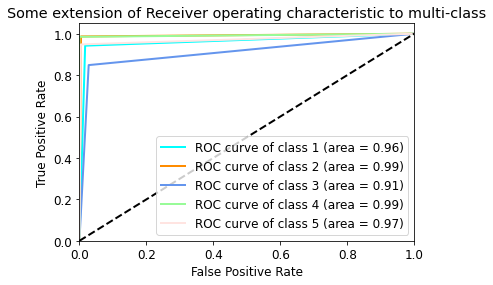

accuracy is: 0.9545454545454547
precision_weighted is 0.9560830678755208
recall_weighted is 0.9545454545454547
f1_weighted is 0.955143205607602


In [ ]:
mvdd = mvGen.generateTreeCrossValidation(xData=xData, yData=yData, classes=["1", "2", "3", "4", "5"], 
                                  learningCriteria='gini', maxLevels=None, minSamplesPerLeaf=3, 
                                                 modelName='TreeFiles/AllData_AllOutcomes', numFolds=5)


In [ ]:
# accList = scores['test_accuracy']
# print("Accuracy: %0.3f (+/- %0.3f)" % (accList.mean(), accList.std() * 2))
# precList = scores['test_precision_weighted']
# print("Precision: %0.3f (+/- %0.3f)" % (precList.mean(), precList.std() * 2))
# recList = scores['test_recall_weighted']
# print("Recall: %0.3f (+/- %0.3f)" % (recList.mean(), recList.std() * 2))
# f1List = scores['test_f1_weighted']
# print("F1: %0.3f (+/- %0.3f)" % (f1List.mean(), f1List.std() * 2))
# rocList = scores['test_roc_auc_ovr_weighted']
# print("AUC: %0.3f (+/- %0.3f)" % (rocList.mean(), rocList.std() * 2))

## Death Label

In [ ]:
yData = death

mvdd = mvGen.generateTreeCrossValidation(xData=xData, yData=yData, classes=["1", "2", "3", "4", "5"], 
                                  learningCriteria='gini', maxLevels=None, minSamplesPerLeaf=3, 
                                                 modelName='TreeFiles/AllData_Death', numFolds=5)


In [ ]:
# accList = scores['test_accuracy']
# print("Accuracy: %0.3f (+/- %0.3f)" % (accList.mean(), accList.std() * 2))
# precList = scores['test_precision_weighted']
# print("Precision: %0.3f (+/- %0.3f)" % (precList.mean(), precList.std() * 2))
# recList = scores['test_recall_weighted']
# print("Recall: %0.3f (+/- %0.3f)" % (recList.mean(), recList.std() * 2))
# f1List = scores['test_f1_weighted']
# print("F1: %0.3f (+/- %0.3f)" % (f1List.mean(), f1List.std() * 2))
# rocList = scores['test_roc_auc_ovr_weighted']
# print("AUC: %0.3f (+/- %0.3f)" % (rocList.mean(), rocList.std() * 2))

## Rehospitalization Label

In [ ]:
yData = rehosp

mvdd, scores = mvGen.generateTreeCrossValidation(xData=xData, yData=yData, classes=["1", "2", "3", "4", "5"], 
                                  learningCriteria='gini', maxLevels=None, minSamplesPerLeaf=3, 
                                                 modelName='TreeFiles/AllData_Rehosp', numFolds=5)

In [ ]:
# accList = scores['test_accuracy']
# print("Accuracy: %0.3f (+/- %0.3f)" % (accList.mean(), accList.std() * 2))
# precList = scores['test_precision_weighted']
# print("Precision: %0.3f (+/- %0.3f)" % (precList.mean(), precList.std() * 2))
# recList = scores['test_recall_weighted']
# print("Recall: %0.3f (+/- %0.3f)" % (recList.mean(), recList.std() * 2))
# f1List = scores['test_f1_weighted']
# print("F1: %0.3f (+/- %0.3f)" % (f1List.mean(), f1List.std() * 2))
# rocList = scores['test_roc_auc_ovr_weighted']
# print("AUC: %0.3f (+/- %0.3f)" % (rocList.mean(), rocList.std() * 2))

## Readmission Label

In [ ]:
yData = readm

mvdd= mvGen.generateTreeCrossValidation(xData=xData, yData=yData, classes=["1", "2", "3", "4", "5"], 
                                  learningCriteria='gini', maxLevels=None, minSamplesPerLeaf=3, 
                                                 modelName='TreeFiles/AllData_Readmission', numFolds=5)


In [ ]:
# accList = scores['test_accuracy']
# print("Accuracy: %0.3f (+/- %0.3f)" % (accList.mean(), accList.std() * 2))
# precList = scores['test_precision_weighted']
# print("Precision: %0.3f (+/- %0.3f)" % (precList.mean(), precList.std() * 2))
# recList = scores['test_recall_weighted']
# print("Recall: %0.3f (+/- %0.3f)" % (recList.mean(), recList.std() * 2))
# f1List = scores['test_f1_weighted']
# print("F1: %0.3f (+/- %0.3f)" % (f1List.mean(), f1List.std() * 2))
# rocList = scores['test_roc_auc_ovr_weighted']
# print("AUC: %0.3f (+/- %0.3f)" % (rocList.mean(), rocList.std() * 2))